In [15]:
from __future__ import print_function
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Flatten
from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback, ModelCheckpoint

In [2]:
np.random.seed(1671) #for reproducibility

In [3]:
# network and training
NB_EPOCH = 250
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASS = 10 #number of outputs = number of digits
OPTIMIZER = SGD() # SGD Optimizer
N_HIDDEN = 128
VALIDATION_SPLIT =0.2 # how much TRAIN is reserved for VALIDATION
DROPOUT = 0.3

In [4]:
# data shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
RESHAPED = 784

In [5]:
X_train = X_train.reshape(60000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [6]:
# normalize
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train sample')
print(X_test.shape[0], 'test samples')

60000 train sample
10000 test samples


In [7]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, NB_CLASS)
Y_test = np_utils.to_categorical(y_test, NB_CLASS)

In [8]:
# 10 outputs
# final stage is softmax
model = Sequential()
model.add(Dense(NB_CLASS, input_shape=(RESHAPED,)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASS))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1408      
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
__________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [10]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
LiveTraining = PlotLearning()

In [13]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True



In [17]:
callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
             LiveTraining,
             ModelCheckpoint('./weights.{epoch:04d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True)]

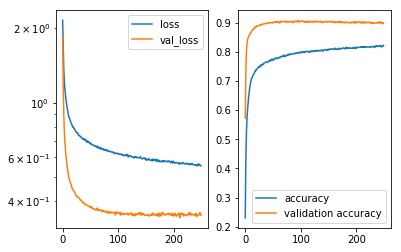

48000/48000 [==============================] - 1s 26us/step - loss: 0.5550 - acc: 0.8217 - val_loss: 0.3503 - val_acc: 0.8994


In [18]:
history = model.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NB_EPOCH,
                    callbacks=callbacks,
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

In [19]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


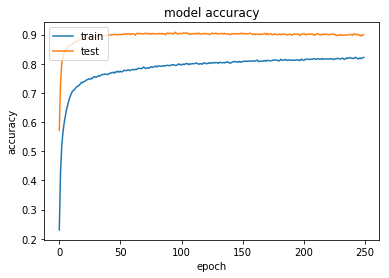

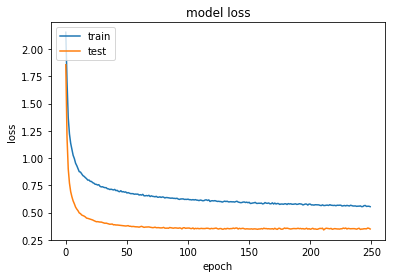

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.subplot(1, 2, 1)

In [21]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("Test score:", score[0])
print("Test accuracy", score[1])

10000/10000 [==============================] - 0s 22us/step
Test score: 0.356882188249
Test accuracy 0.8952
